# Multi-Armed Bandits and Reinforcement Learning with Amazon SageMaker

We demonstrate how you can manage your own contextual multi-armed bandit workflow on SageMaker using the built-in [AWS Reinforcement Learning Container](https://github.com/aws/sagemaker-rl-container) container to train and deploy contextual bandit models. We show how to train these models that interact with a live environment (using a simulated client application) and continuously update the model with efficient exploration.

### Why Contextual Bandits?

Wherever we look to personalize content for a user (content layout, ads, search, product recommendations, etc.), contextual bandits come in handy. Traditional personalization methods collect a training dataset, build a model and deploy it for generating recommendations. However, the training algorithm does not inform us on how to collect this dataset, especially in a production system where generating poor recommendations lead to loss of revenue. Contextual bandit algorithms help us collect this data in a strategic manner by trading off between exploiting known information and exploring recommendations which may yield higher benefits. The collected data is used to update the personalization model in an online manner. Therefore, contextual bandits help us train a personalization model while minimizing the impact of poor recommendations.

![](img/multi_armed_bandit_maximize_reward.png)

To implement the exploration-exploitation strategy, we need an iterative training and deployment system that: (1) recommends an action using the contextual bandit model based on user context, (2) captures the implicit feedback over time and (3) continuously trains the model with incremental interaction data. In this notebook, we show how to setup the infrastructure needed for such an iterative learning system. While the example demonstrates a bandits application, these continual learning systems are useful more generally in dynamic scenarios where models need to be continually updated to capture the recent trends in the data (e.g. tracking fraud behaviors based on detection mechanisms or tracking user interests over time). 

In a typical supervised learning setup, the model is trained with a SageMaker training job and it is hosted behind a SageMaker hosting endpoint. The client application calls the endpoint for inference and receives a response. In bandits, the client application also sends the reward (a score assigned to each recommendation generated by the model) back for subsequent model training. These rewards will be part of the dataset for the subsequent model training. 

# Relevant Links

In-Practice
* [AWS Blog Post on Contextual Multi-Armed Bandits](https://aws.amazon.com/blogs/machine-learning/power-contextual-bandits-using-continual-learning-with-amazon-sagemaker-rl/)
* [Multi-Armed Bandits at StitchFix](https://multithreaded.stitchfix.com/blog/2020/08/05/bandits/)
* [Introduction to Contextual Bandits](https://getstream.io/blog/introduction-contextual-bandits/)
* [Vowpal Wabbit Contextual Bandit Algorithms](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Contextual-Bandit-algorithms)

Theory
* [Learning to Interact](https://hunch.net/~jl/interact.pdf)
* [Contextual Bandit Bake-Off](https://arxiv.org/pdf/1802.04064.pdf)
* [Doubly-Robust Policy Evaluation and Learning](https://arxiv.org/pdf/1103.4601.pdf)

Code
* [AWS Open Source Reinforcement Learning Containers](https://github.com/aws/sagemaker-rl-container)
* [AWS Open Source Bandit Experiment Manager](./common/sagemaker_rl/orchestrator/workflow/manager)
* [Vowpal Wabbit Reinforcement Learning Framework](https://github.com/VowpalWabbit/)

# AWS Open Source Bandit `ExperimentManager` Library

![](img/multi_armed_bandit_traffic_shift.png)

The bandit model is implemented by the open source [**Bandit Experiment Manager**](./common/sagemaker_rl/orchestrator/workflow/manager/) provided with this example.  This This implementation continuously updates a Vowpal Wabbit reinforcement learning model using Amazon SageMaker, DynamoDB, Kinesis, and S3.

The client application, a recommender system with a review service in our case, pings the SageMaker hosting endpoint that is serving the bandit model.  The application sends the an `event` with the `context` (ie. user, product, and review text) to the bandit model and receives a recommended action from the bandit model.  In our case, the action is 1 of 2 BERT models that we are testing.  The bandit model stores this event data (given context and recommended action) in S3 using Amazon Kinesis.  _Note:  The context makes this a "contextual bandit" and differentiates this implementation from a regular multi-armed bandit._

The client application uses the recommended BERT model to classify the review text as star rating 1 through 5 and  compares the predicted star rating to the user-selected star rating.  If the BERT model correctly predicts the star rating of the review text (ie. matches the user-selected star rating), then the bandit model is rewarded with `reward=1`.  If the BERT model incorrectly classifies the star rating of the review text, the bandit model is not rewarded (`reward=0`).

The client application stores the rewards data in S3 using Amazon Kinesis.  Periodically (ie. every 100 rewards), we incrementally train an updated bandit model with the latest the reward and event data.  This updated bandit model is evaluated against the current model using a holdout dataset of rewards and events.  If the bandit model accuracy is above a given threshold relative to the existing model, it is automatically deployed in a blue/green manner with no downtime.  SageMaker RL supports offline evaluation by performing counterfactual analysis (CFA).  By default, we apply [**doubly robust (DR) estimation**](https://arxiv.org/pdf/1103.4601.pdf) method. The bandit model tries to minimize the cost (`1 - reward`), so a smaller evaluation score indicates better bandit model performance.

Unlike traditional A/B tests, the bandit model will learn the best BERT model (action) for a given context over time and begin to shift traffic to the best model.  Depending on the aggressiveness of the bandit model algorithm selected, the bandit model will continuously explore the under-performing models, but start to favor and exploit the over-performing models.  And unlike A/B tests, multi-armed bandits allow you to add a new action (ie. BERT model) dynamically throughout the life of the experiment.  When the bandit model sees the new BERT model, it will start sending traffic and exploring the accuracy of the new BERT model - alongside the existing BERT models in the experiment.

#### Local Mode

To facilitate experimentation, we provide a `local_mode` that runs the contextual bandit example using the SageMaker Notebook instance itself instead of the SageMaker training and hosting cluster instances.  The workflow remains the same in `local_mode`, but runs much faster for small datasets.  Hence, it is a useful tool for experimenting and debugging.  However, it will not scale to production use cases with high throughput and large datasets.  In `local_mode`, the training, evaluation, and hosting is done in the local [SageMaker Vowpal Wabbit Docker Container](https://github.com/aws/sagemaker-rl-container).

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [23]:
import yaml
import sys
import numpy as np
import time
import sagemaker

sys.path.append('common')
sys.path.append('common/sagemaker_rl')

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Configuration

The configuration for the bandits application can be specified in a `config.yaml` file as can be seen below. It configures the AWS resources needed. The DynamoDB tables are used to store metadata related to experiments, models and data joins. The `private_resource` specifices the SageMaker instance types and counts used for training, evaluation and hosting. The SageMaker container image is used for the bandits application. This config file also contains algorithm and SageMaker-specific setups.  Note that all the data generated and used for the bandits application will be stored in `s3://sagemaker-{REGION}-{AWS_ACCOUNT_ID}/{experiment_id}/`.

Please make sure that the `num_arms` parameter in the config is equal to the number of actions in the client application (which is defined in the cell below).

The Docker image is defined here:  https://github.com/aws/sagemaker-rl-container/blob/master/vw/docker/8.7.0/Dockerfile

In [36]:
!pygmentize 'config.yaml'

resource:
  shared_resource:
    resources_cf_stack_name: "BanditsSharedResourceStack" # cloud formation stack
    experiment_db:
      table_name: "BanditsExperimentTable" # Dynamo table for status of an experiment
    model_db:
      table_name: "BanditsModelTable" # Dynamo table for status of all models trained
    join_db:
      table_name: "BanditsJoinTable" # Dynamo table for status of all joining job for reward ingestion
    iam_role:
      role_name: "BanditsIAMRole"
  private_resource:
    hosting_fleet:
      instance_type: "ml.t2.medium"
      instance_count: 1
    training_fleet:
      instance_type: "ml.c5.4xlarge"
    evaluation_fleet:
      instance_type: "ml.c5.4xlarge"
image: "462105765813.dkr.ecr.{AWS_REGION}.amazonaws.com/sagemaker-rl-vw-container:vw-8.7.0-cpu" # Vowpal Wabbit container
algor: # Vowpal Wabbit algorithm parameters
  algorithms_parameters:
    exploration_policy: "cover" # supports "egreedy", "bag", "cover"
    epsilon: 0.10 # percent to explore with e

In [37]:
config_file = 'config.yaml'
with open(config_file, 'r') as yaml_file:
    config = yaml.load(yaml_file, Loader=yaml.FullLoader)

### Client Application (Environment)
The client application simulates a live environment that uses the bandit model to recommend a BERT model to classify review text submitted by the application user. 

The logic of reward generation resides in the client application.  We simulate the online learning loop with feedback.  The data consists of 2 actions - 1 for each BERT model under test.  If the bandit model selects the right class, then the model is rewarded with `reward=1`.  Otherwise, the bandit model receives `reward=0`.

The workflow of the client application is as follows:
- Our client application picks sample review text at random, which is sent to the bandit model (SageMaker endpoint) to recommend an action (BERT model) to classify the review text into star rating 1 through 5.
- The bandit model returns an action, an action probability, and an `event_id` for this prediction event.
- Since the client application uses the Amazon Customer Reviews Dataset, we know the true star rating for the review text
- The client application compares the predicted and true star rating and assigns a reward to the bandit model using Amazon Kinesis, S3, and DynamoDB.  (The `event_id` is used to join the event and reward data.)

`event_id` is a unique identifier for each interaction. It is used to join inference data `<state, action, action_probability>` with the reward data. 

In a later cell of this notebook, we illustrate how the client application interacts with the bandit model endpoint and receives the recommended action (BERT model).

### Step-by-step bandits model development

[**Bandit Experiment Manager**](./common/sagemaker_rl/orchestrator/workflow/manager/) is the top level class for all the Bandits/RL and continual learning workflows. Similar to the estimators in the [Sagemaker Python SDK](https://github.com/aws/sagemaker-python-sdk), `ExperimentManager` contains methods for training, deployment and evaluation. It keeps track of the job status and reflects current progress in the workflow.

Start the application using the `ExperimentManager` class 

In [39]:
import time
timestamp = int(time.time())

experiment_name = 'bandits-{}'.format(timestamp)

# `ExperimentManager` will create a AWS CloudFormation Stack of additional resources needed for the Bandit experiment. 

In [40]:
from orchestrator.workflow.manager.experiment_manager import ExperimentManager

bandit_experiment_manager = ExperimentManager(config, experiment_id=experiment_name)

INFO:orchestrator.resource_manager:Using Resources in CloudFormation stack named: BanditsSharedResourceStack for Shared Resources.


# Initialize the Client Application

In [63]:
import csv
import numpy as np

class ClientApp():
    def __init__(self, data, num_events, bandit_model, bert_model_map):
        self.bandit_model = bandit_model
        self.bert_model_map = bert_model_map
        
        self.num_actions = 2

        df_reviews = pd.read_csv(data, 
                                 delimiter='\t', 
                                 quoting=csv.QUOTE_NONE,
                                 compression='gzip')
        df_scrubbed = df_reviews[['review_body', 'star_rating']].sample(n=num_events) # .query('star_rating == 1')
        df_scrubbed = df_scrubbed.reset_index()
        df_scrubbed.shape
        np_reviews = df_scrubbed.to_numpy()

        np_reviews = np.delete(np_reviews, 0, 1)
        
        # Last column is the label, the rest are the features (contexts)
        self.labels = np_reviews[:, -1]
        self.contexts = np_reviews[:, :-1].tolist()

        self.optimal_rewards = [1]
        self.rewards_tmp_buffer = []
        self.joined_data_tmp_buffer = []
        self.all_joined_data_buffer = []
        
        self.action_count = {}

    def increment_action_count(self, action):
        try:
            action_count = self.action_count[action]
        except:
            self.action_count[action] = 0
            action_count = 0
            
        self.action_count[action] = action_count + 1
                
    def choose_random_context(self):
        context_index = np.random.choice(len(self.contexts))
        context = self.contexts[context_index]
        return context_index, context    

    def clear_tmp_buffers(self):
        self.rewards_tmp_buffer.clear()
        self.joined_data_tmp_buffer.clear()

    def get_reward(self, 
                   context_index, 
                   action, 
                   event_id, 
                   bandit_model_id, 
                   action_prob, 
                   sample_prob, 
                   local_mode):

        context_to_predict = self.contexts[context_index][0]
    
        label = self.labels[context_index]
        
        bert_model = self.bert_model_map[action]

        self.increment_action_count(action)
        
        # TensorFlow returns [str]
        if (action == 1):
            bert_predicted_class = bert_model.predict(context_to_predict)[0]
            bert_predicted_class
            print('Predicted Class from Model 1: {}, Actual Class: {}'.format(bert_predicted_class, label))

        # PyTorch returns bytes
        if (action == 2):
            bert_predicted_class = bert_model.predict({"review_body": context_to_predict})
            bert_predicted_class = bert_predicted_class# .decode('utf-8')
            print('Predicted Class from Model 2: {}, Actual Class: {}'.format(bert_predicted_class, label))
            
       # Calculate difference between predicted and actual label
        if abs(int(bert_predicted_class) - int(label)) == 0:
            reward = 1
        else:
            reward = 0

        if local_mode:
            json_blob = {
                         "reward": reward,
                         "event_id": event_id,
                         "action": action,
                         "action_prob": action_prob,
                         "model_id": bandit_model_id,
                         "observation": [context_index],
                         "sample_prob": sample_prob
                        }
            
            self.joined_data_tmp_buffer.append(json_blob)            
        else:
            json_blob = {
                         "reward": reward, 
                         "event_id": event_id
                        }
            self.rewards_tmp_buffer.append(json_blob)
        
        return reward
    

In [64]:
bandit_model = bandit_experiment_manager.predictor

client_app = ClientApp(data='./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz',
                       num_events=100,
                       bandit_model=bandit_model,
                       bert_model_map={
                         1: model1,
                         2: model2
                       })

# Train the Bandit Model

Now we can train a new model with newly collected experiences, and host the resulting model.

In [73]:
bandit_experiment_manager.train_next_model(input_data_s3_prefix=bandit_experiment_manager.last_joined_job_train_data)

Trained bandit model id bandits-1610163172-model-id-1610163261


INFO:orchestrator:Use last trained model bandits-1610163172-model-id-1610163261 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1610163172-model-id-1610163337''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating 7ru878yq03-algo-1-2mrdy ... 
Attaching to 7ru878yq03-algo-1-2mrdy2mdone
7ru878yq03-algo-1-2mrdy | 2021-01-09 03:35:40,003 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
7ru878yq03-algo-1-2mrdy | 2021-01-09 03:35:40,013 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
7ru878yq03-algo-1-2mrdy | 2021-01-09 03:35:40,025 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
7ru878yq03-algo-1-2mrdy | 2021-01-09 03:35:40,033 sagemaker-containers INFO     Invoking user script
7ru878yq03-algo-1-2mrdy | 
7ru878yq03-algo-1-2mrdy | Training Env:
7ru878yq03-algo-1-2mrdy | 
7ru878yq03-algo-1-2mrdy | {
7ru878yq03-algo-1-2mrdy |     "additional_framework_parameters": {
7ru878yq03-algo-1-2mrdy |         "sagemaker_estimator": "RLEstimator"
7ru878yq03-algo-1-2mrdy |     },
7ru878yq03-algo-1-2mrdy |     "channel_input_dirs": {
7ru878yq03-algo-1-2mrdy |         "training": "/opt/ml/input/data/training",
7ru878yq03-al

7ru878yq03-algo-1-2mrdy exited with code 0
Aborting on container exit...
===== Job Complete =====


# Deploy the Bandit Model

In [74]:
print('Deploying bandit model id {}'.format(bandit_experiment_manager.last_trained_model_id))

bandit_experiment_manager.deploy_model(model_id=bandit_experiment_manager.last_trained_model_id)

Deploying bandit model id bandits-1610163172-model-id-1610163261


INFO:orchestrator:Model 'bandits-1610163172-model-id-1610163337' is ready to deploy.


tfwd76283e-algo-1-h18li | [01/09/2021 03:35:51 INFO 140070204577536] Found new model! Trying to replace Model ID: bandits-1610163172-model-id-1610163261 with Model ID: bandits-1610163172-model-id-1610163337
tfwd76283e-algo-1-h18li | [2021-01-09 03:35:51 +0000] [25] [INFO] Handling signal: hup
tfwd76283e-algo-1-h18li | [2021-01-09 03:35:51 +0000] [25] [INFO] Hang up: Master
tfwd76283e-algo-1-h18li | [2021-01-09 03:35:51 +0000] [54] [INFO] Booting worker with pid: 54
tfwd76283e-algo-1-h18li | [2021-01-09 03:35:51 +0000] [55] [INFO] Booting worker with pid: 55
tfwd76283e-algo-1-h18li | [01/09/2021 03:35:51 INFO 140070204577536] creating an instance of VWModel
tfwd76283e-algo-1-h18li | [01/09/2021 03:35:51 INFO 140070204577536] successfully created VWModel
tfwd76283e-algo-1-h18li | [01/09/2021 03:35:51 INFO 140070204577536] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/q8HG0p0B/vw.model']
tfwd76283e-algo-1-h18li 

# Check Experiment Status:  DEPLOYED
`deploying_state`:  `SUCCEEDED`

In [75]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1610163172',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-1610163172-model-id-1610163337',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': <HostingState.DEPLOYED: 'DEPLOYED'>,
  'last_hosted_model_id': 'bandits-1610163172-model-id-1610163337',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': 'SUCCEEDED',
  'last_joined_job_id': 'bandits-1610163172-join-job-id-1610163328',
  'next_join_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': None,
  'last_evaluation_job_id': None,
  'next_evaluation_job_id': None}}

# Continuously Train, Evaluate, and Deploy Bandit Models
The above cells explained the individual steps in the training workflow. To train a model to convergence, we will continually train the model based on data collected with client application interactions. We demonstrate the continual training and evaluation loop in a single cell below.

_**Train and Evaluate**_:
After every training cycle, we evaluate if the newly trained model (`last_trained_model_id`) would perform better than the one currently deployed (`last_hosted_model_id`) using a holdout evaluation dataset.  Details of the join, train, and evaluation steps are tracked in the `BanditsJoinTable` and `BanditsModelTable` DynamoDB tables.  When you have multiple experiments, you can compare them in the `BanditsExperimentTable` DynamoDB table.

_**Deploy**_: If the new bandit model is better than the current bandit model (based on offline evaluation), we will automatically deploy the new bandit model using a blue-green deployment to avoid downtime.

In [ ]:
do_evaluation = True
total_loops = 5 # Increase for higher accuracy
retrain_batch_size = 100 # Model will be trained after every `batch_size` number of data instances
rewards_list = []
event_list = []

all_joined_train_data_s3_uri_list = []
all_joined_eval_data_s3_uri_list = []

local_mode = bandit_experiment_manager.local_mode

start_time = time.time()
for loop_no in range(total_loops):
    print(f"""
    ################################
    # Incremental Training Loop {loop_no+1}
    ################################
    """)
    
    # Generate experiences and log them
    for i in range(retrain_batch_size):
        context_index, context = client_app.choose_random_context()
        action, event_id, bandit_model_id, action_prob, sample_prob = bandit_model.get_action(obs=[context_index])

        reward = client_app.get_reward(context_index=context_index, 
                                       action=action, 
                                       event_id=event_id, 
                                       bandit_model_id=bandit_model_id, 
                                       action_prob=action_prob, 
                                       sample_prob=sample_prob, 
                                       local_mode=local_mode)

        rewards_list.append(reward)
        
    # Publish rewards sum for this batch to CloudWatch for monitoring 
    bandit_experiment_manager.cw_logger.publish_rewards_for_simulation(
        bandit_experiment_manager.experiment_id,
        sum(rewards_list[-retrain_batch_size:])/retrain_batch_size
    )
    
    # Join the events and rewards data to use for the next bandit-model training job
    # Use 90% as the training dataset and 10% as the the holdout evaluation dataset
    if local_mode:        
        bandit_experiment_manager.ingest_joined_data(client_app.joined_data_tmp_buffer,
                                                     ratio=0.90)
    else:
        # Kinesis Firehose => S3 => Athena
        print('Waiting for firehose to flush data to s3...')
        time.sleep(60) 
        rewards_s3_prefix = bandit_experiment_manager.ingest_rewards(client_app.rewards_tmp_buffer)
        bandit_experiment_manager.join(rewards_s3_prefix, ratio=0.90)
            
    # Train 
    bandit_experiment_manager.train_next_model(
        input_data_s3_prefix=bandit_experiment_manager.last_joined_job_train_data)

    all_joined_train_data_s3_uri_list.append(bandit_experiment_manager.last_joined_job_train_data)

    # Evaluate and/or deploy the new bandit model
    if do_evaluation:
        bandit_experiment_manager.evaluate_model(
            input_data_s3_prefix=bandit_experiment_manager.last_joined_job_eval_data,
            evaluate_model_id=bandit_experiment_manager.last_trained_model_id)

        eval_score_last_trained_model = bandit_experiment_manager.get_eval_score(
            evaluate_model_id=bandit_experiment_manager.last_trained_model_id,
            eval_data_path=bandit_experiment_manager.last_joined_job_eval_data)

        bandit_experiment_manager.evaluate_model(
            input_data_s3_prefix=bandit_experiment_manager.last_joined_job_eval_data,
            evaluate_model_id=bandit_experiment_manager.last_hosted_model_id) 

        all_joined_eval_data_s3_uri_list.append(bandit_experiment_manager.last_joined_job_eval_data)
    
        # Eval score is a measure of `regret`, so a lower eval score is better
        eval_score_last_hosted_model = bandit_experiment_manager.get_eval_score(
            evaluate_model_id=bandit_experiment_manager.last_hosted_model_id, 
            eval_data_path=bandit_experiment_manager.last_joined_job_eval_data)
    
        print('New bandit model evaluation score {}'.format(eval_score_last_hosted_model))
        print('Current bandit model evaluation score {}'.format(eval_score_last_trained_model))

        if eval_score_last_trained_model <= eval_score_last_hosted_model:
            print('Deploying new bandit model id {} in loop {}'.format(bandit_experiment_manager.last_trained_model_id, loop_no))
            bandit_experiment_manager.deploy_model(model_id=bandit_experiment_manager.last_trained_model_id)
        else:
            print('Not deploying bandit model id {} in loop {}'.format(bandit_experiment_manager.last_trained_model_id, loop_no))
    else:
        # Just deploy the new bandit model without evaluating against previous model
        print('Deploying new bandit model id {} in loop {}'.format(bandit_experiment_manager.last_trained_model_id, loop_no))
        bandit_experiment_manager.deploy_model(model_id=bandit_experiment_manager.last_trained_model_id)
    
    client_app.clear_tmp_buffers()
    
print(f'Total time taken to complete {total_loops} loops: {time.time() - start_time}')

# Review Invocations of BERT Model 1 and 2

In [82]:
print('Total Invocations of BERT Model 1:  {}'.format(client_app.action_count[1]))
print('Total Invocations of BERT Model 2:  {}'.format(client_app.action_count[2]))

Total Invocations of BERT Model 1:  322
Total Invocations of BERT Model 2:  278


In [83]:
from datetime import datetime, timedelta

import boto3
import pandas as pd

cw = boto3.Session().client(service_name='cloudwatch', region_name=region)

def get_invocation_metrics_for_endpoint_variant(endpoint_name,
                                                namespace_name,
                                                metric_name,
                                                variant_name,
                                                start_time,
                                                end_time):
    metrics = cw.get_metric_statistics(
        Namespace=namespace_name,
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {
                "Name": "EndpointName",
                "Value": endpoint_name
            },
            {
                "Name": "VariantName",
                "Value": variant_name
            }
        ]
    )

    if metrics['Datapoints']:
        return pd.DataFrame(metrics["Datapoints"])\
                .sort_values("Timestamp")\
                .set_index("Timestamp")\
                .drop("Unit", axis=1)\
                .rename(columns={"Sum": variant_name})
    else:
        return pd.DataFrame()


# Gather BERT Model 1 Invocations Metrics
_Please be patient.  This will take 1-2 minutes._

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(75)

start_time = start_time or datetime.now() - timedelta(minutes=60)
end_time = datetime.now()
        
model_1_endpoint_invocations = get_invocation_metrics_for_endpoint_variant(
                                    endpoint_name=model_1_endpoint_name,
                                    namespace_name='AWS/SageMaker',                                   
                                    metric_name='Invocations',
                                    variant_name='AllTraffic',
                                    start_time=start_time, 
                                    end_time=end_time)

model_1_endpoint_invocations

# Gather BERT Model 2 Invocations Metrics
_Please be patient.  This will take 1-2 minutes._

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(75)

start_time = start_time or datetime.now() - timedelta(minutes=60)
end_time = datetime.now()
        
model_2_endpoint_invocations = get_invocation_metrics_for_endpoint_variant(
                                    endpoint_name=model_2_endpoint_name,
                                    namespace_name='AWS/SageMaker',                                   
                                    metric_name='Invocations',
                                    variant_name='AllTraffic',
                                    start_time=start_time, 
                                    end_time=end_time)

model_2_endpoint_invocations

Text(0, 0.5, 'Number of Invocations')

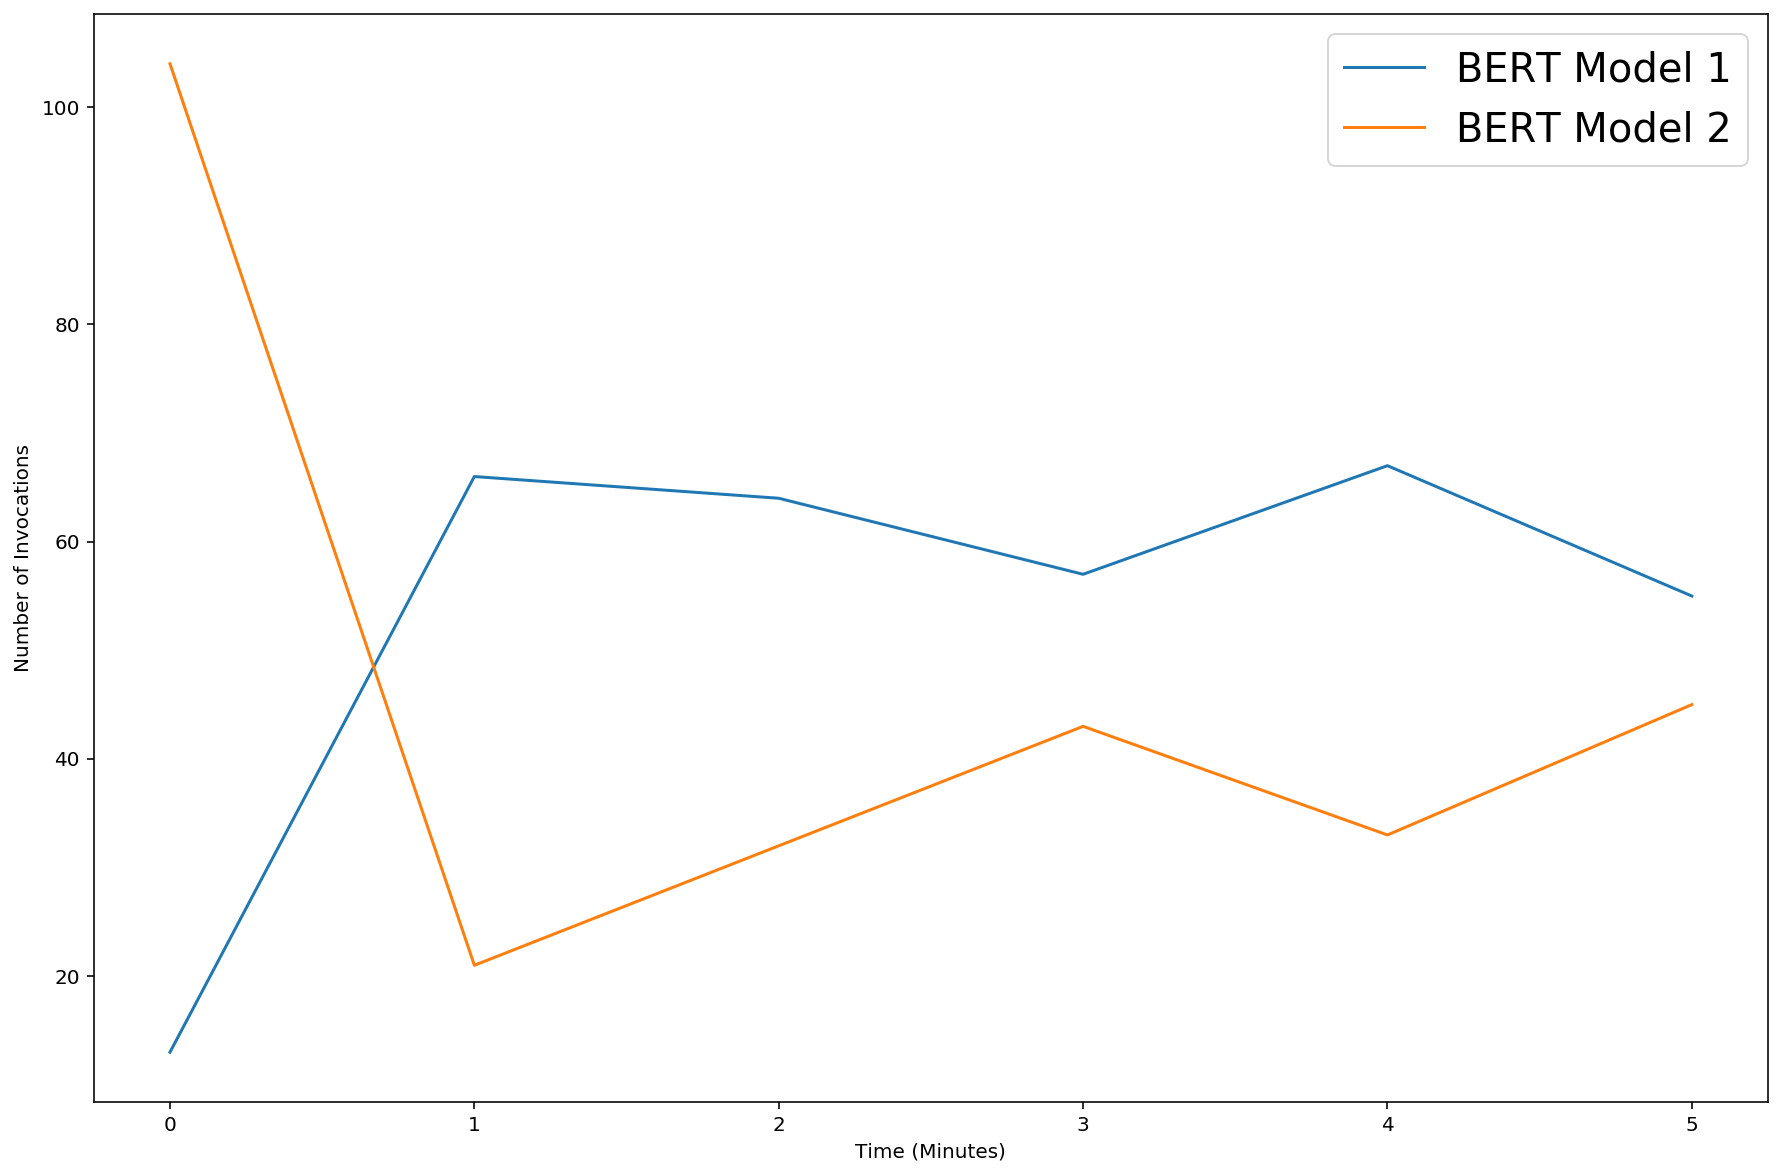

In [86]:
rcParams['figure.figsize'] = 15, 10

x1 = range(0, model_1_endpoint_invocations.size)
y1 = model_1_endpoint_invocations['AllTraffic']
plt.plot(x1, y1, label="BERT Model 1")

x1 = range(0, model_2_endpoint_invocations.size)
y1 = model_2_endpoint_invocations['AllTraffic']
plt.plot(x1, y1, label="BERT Model 2")

plt.legend(loc=0, prop={'size': 20})
plt.xlabel('Time (Minutes)')
plt.ylabel('Number of Invocations')

# Check the Invocation Metrics for the BERT Models

In [87]:
from IPython.core.display import display, HTML
    
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#metricsV2:namespace=AWS/SageMaker;dimensions=EndpointName,VariantName;search={}">Model 1 SageMaker REST Endpoint</a></b>'.format(region, model_1_endpoint_name)))


In [88]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#metricsV2:namespace=AWS/SageMaker;dimensions=EndpointName,VariantName;search={}">Model 2 SageMaker REST Endpoint</a></b>'.format(region, model_2_endpoint_name)))


# Visualize Bandit Action Probabilities
This is the probability that the bandit model will choose a particular BERT model (action).

Text(0, 0.5, 'Action Probability')

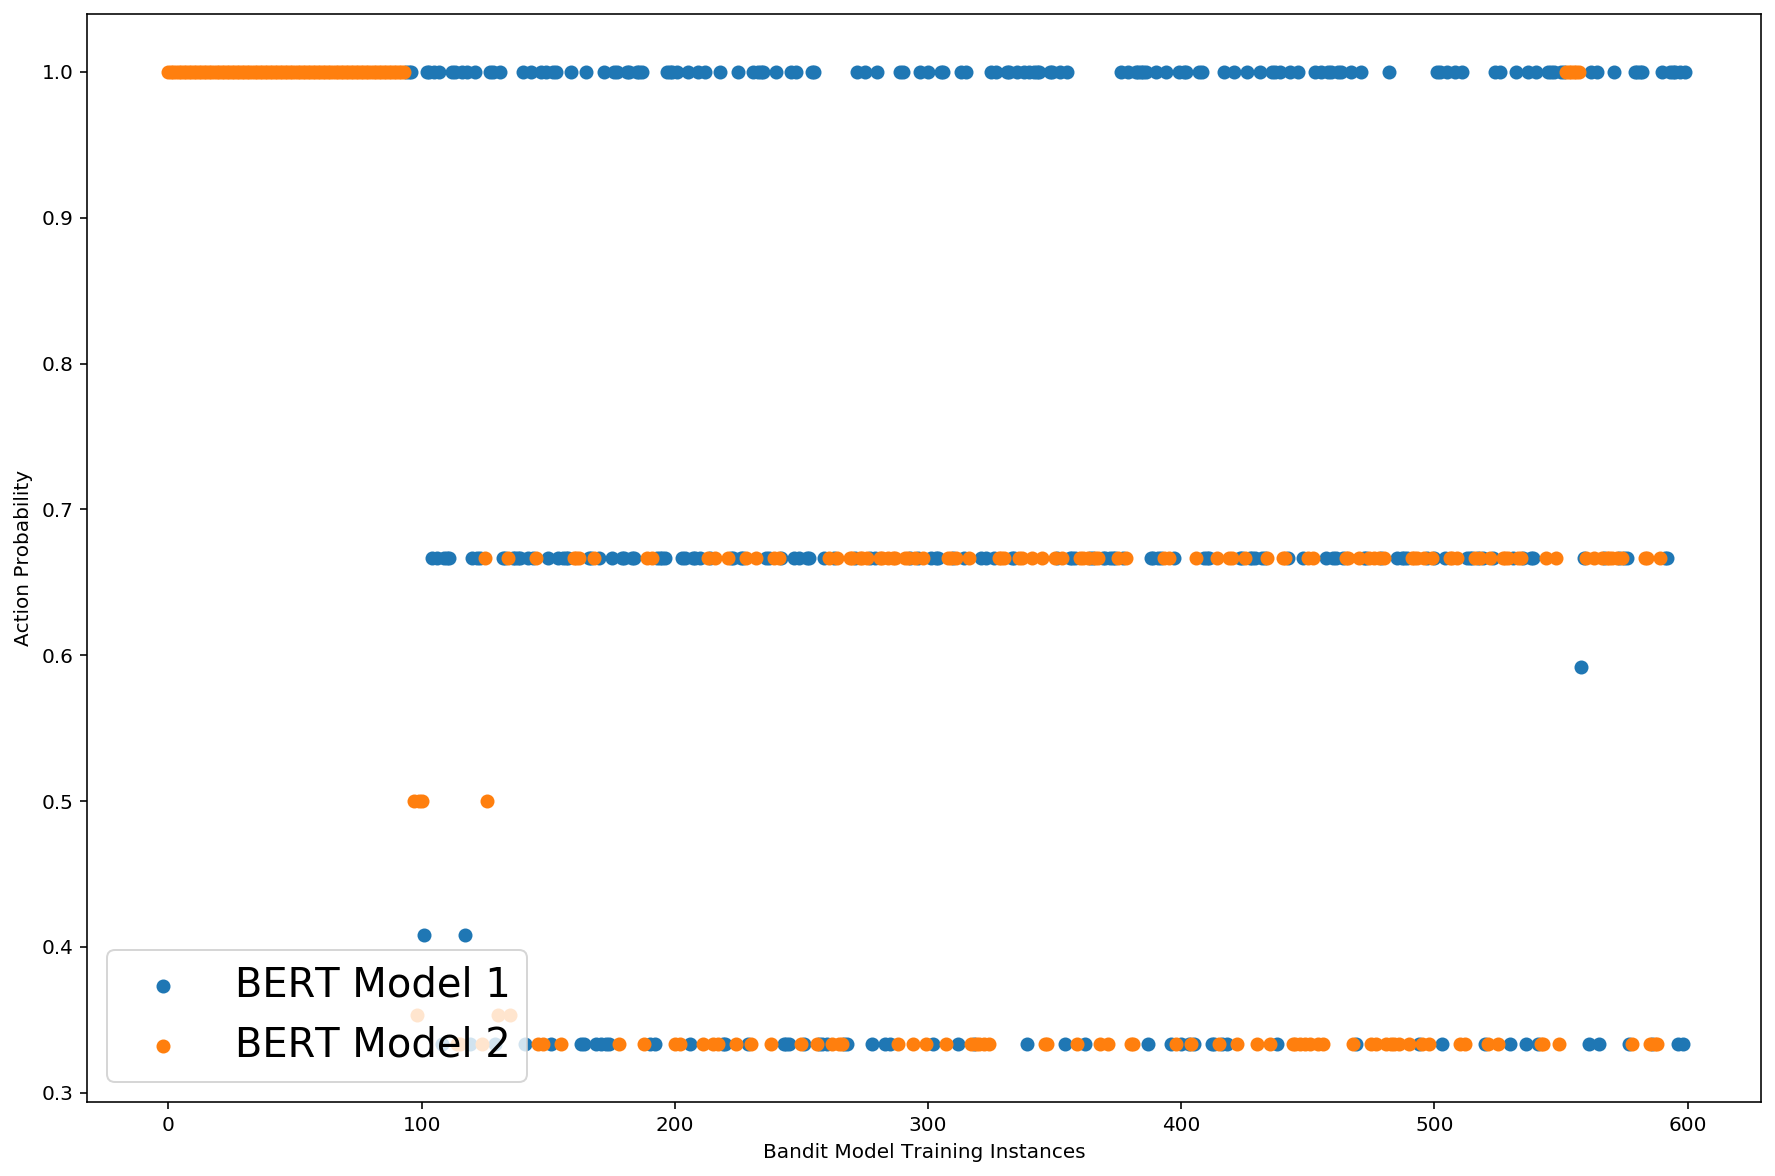

In [89]:
rcParams['figure.figsize'] = 15, 10

x1 = all_joined_data_df.query('action==1').index
y1 = all_joined_data_df.query('action==1').action_prob
plt.scatter(x1, y1, label="BERT Model 1")

x2 = all_joined_data_df.query('action==2').index
y2 = all_joined_data_df.query('action==2').action_prob
plt.scatter(x2, y2, label="BERT Model 2")

plt.legend(loc=3, prop={'size': 20})
plt.xlabel('Bandit Model Training Instances')
plt.ylabel('Action Probability')

In [90]:
print('Mean action probability for BERT Model 1: {}'.format(all_joined_data_df.query('action==1')['action_prob'].mean()))

Mean action probability for BERT Model 1: 0.7435039472049679


In [91]:
print('Mean action probability for BERT Model 2: {}'.format(all_joined_data_df.query('action==2')['action_prob'].mean()))

Mean action probability for BERT Model 2: 0.6956618776978412


# Visualize Bandit Sample Probabilities
Despite the action probability, we sample from all actions (BERT models).  Below is the sample probability for the chosen BERT model.

Text(0, 0.5, 'Sample Probability')

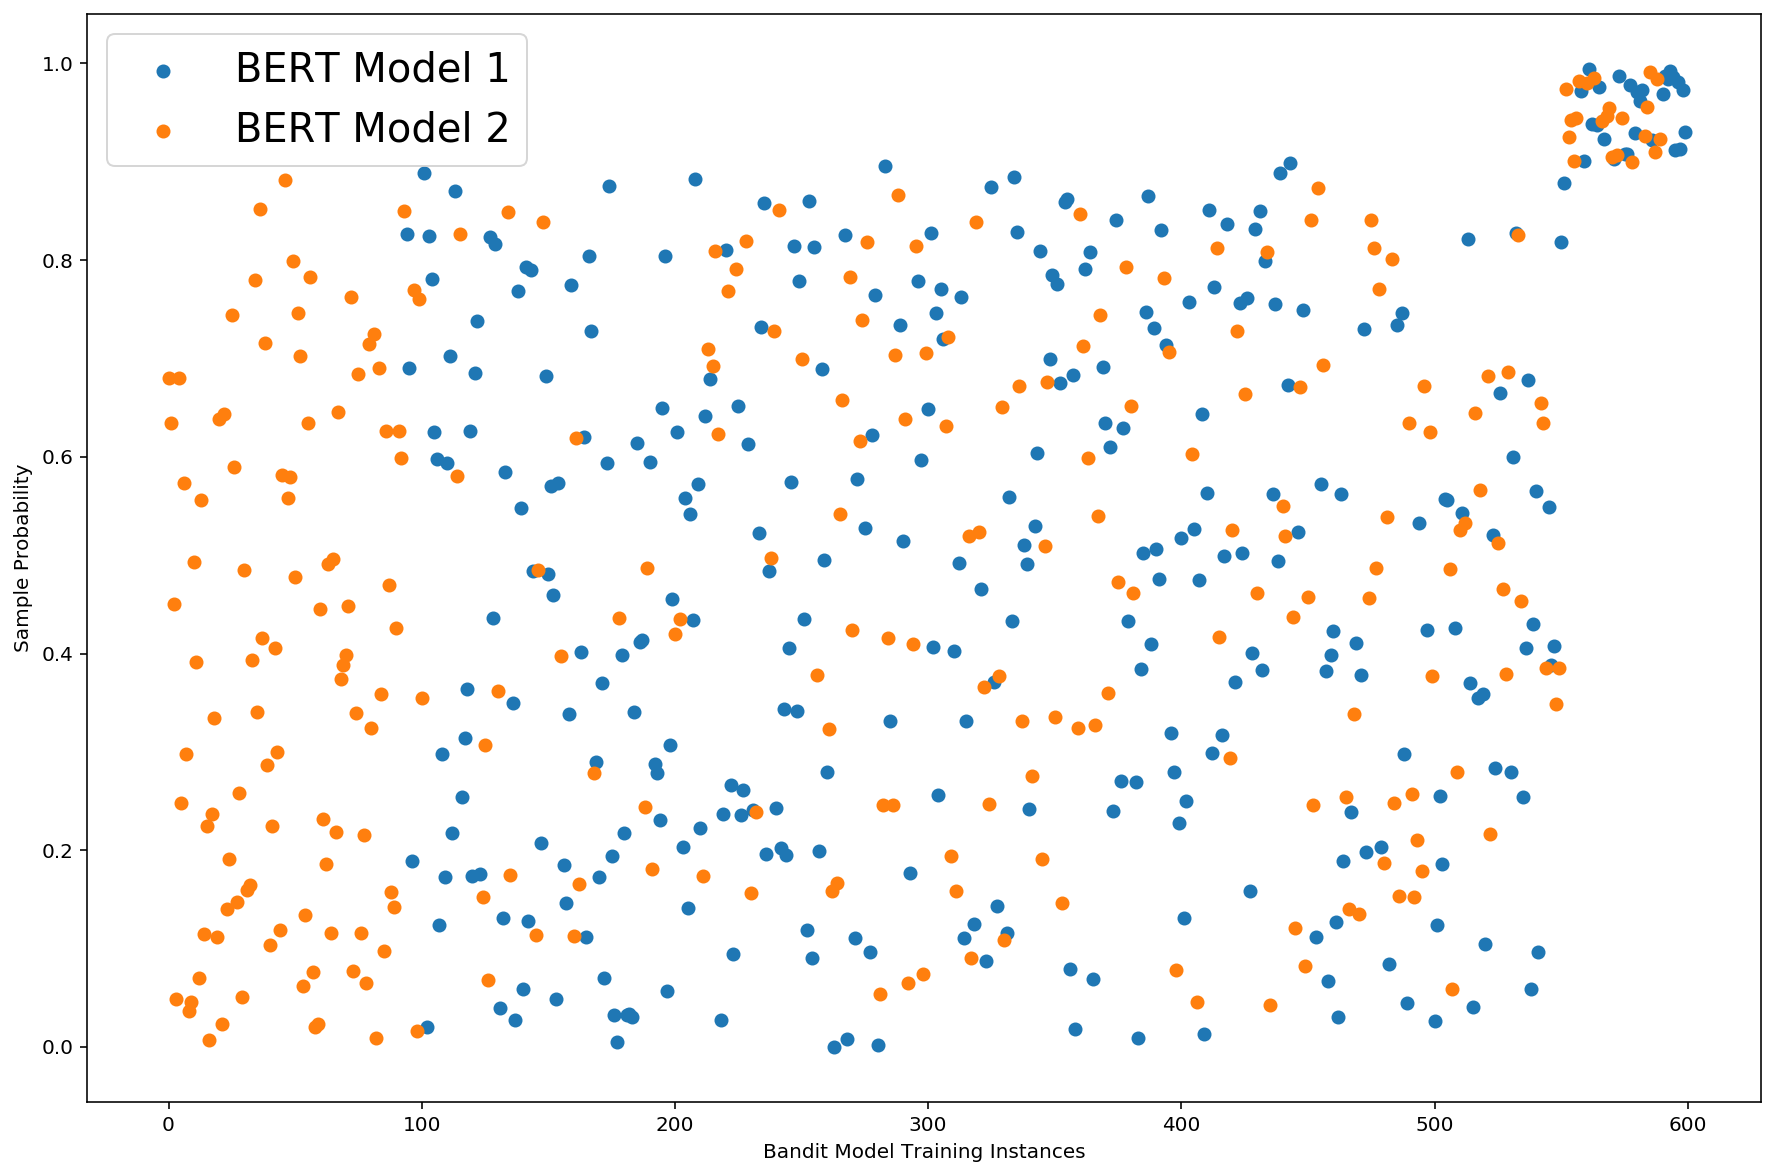

In [104]:
rcParams['figure.figsize'] = 15, 10

x1 = all_joined_data_df.query('action==1').index
y1 = all_joined_data_df.query('action==1').sample_prob
plt.scatter(x1, y1, label="BERT Model 1")

x2 = all_joined_data_df.query('action==2').index
y2 = all_joined_data_df.query('action==2').sample_prob
plt.scatter(x2, y2, label="BERT Model 2")

plt.legend(loc=0, prop={'size': 20})
plt.xlabel('Bandit Model Training Instances')
plt.ylabel('Sample Probability')

In [93]:
print('Mean sample probability for BERT Model 1: {}'.format(all_joined_data_df.query('action==1')['sample_prob'].mean()))

Mean sample probability for BERT Model 1: 0.4991086853034962


In [94]:
print('Mean sample probability for BERT Model 2: {}'.format(all_joined_data_df.query('action==2')['sample_prob'].mean()))

Mean sample probability for BERT Model 2: 0.47657281971124227


# Visualize Bandit Rewards

You can visualize the bandit-model training performance by plotting the rolling mean reward across client interactions.

Here rolling mean reward is calculated on the last `rolling_window` number of data instances, where each data instance corresponds to a single client interaction.

In [ ]:
rolling_window = 100

rcParams['figure.figsize'] = 15, 10
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

rewards_df = pd.DataFrame(rewards_list, columns=['bandit']).rolling(rolling_window).mean()
#rewards_df['perfect'] = sum(client_app.optimal_rewards) / len(client_app.optimal_rewards)

rewards_df.tail(10)

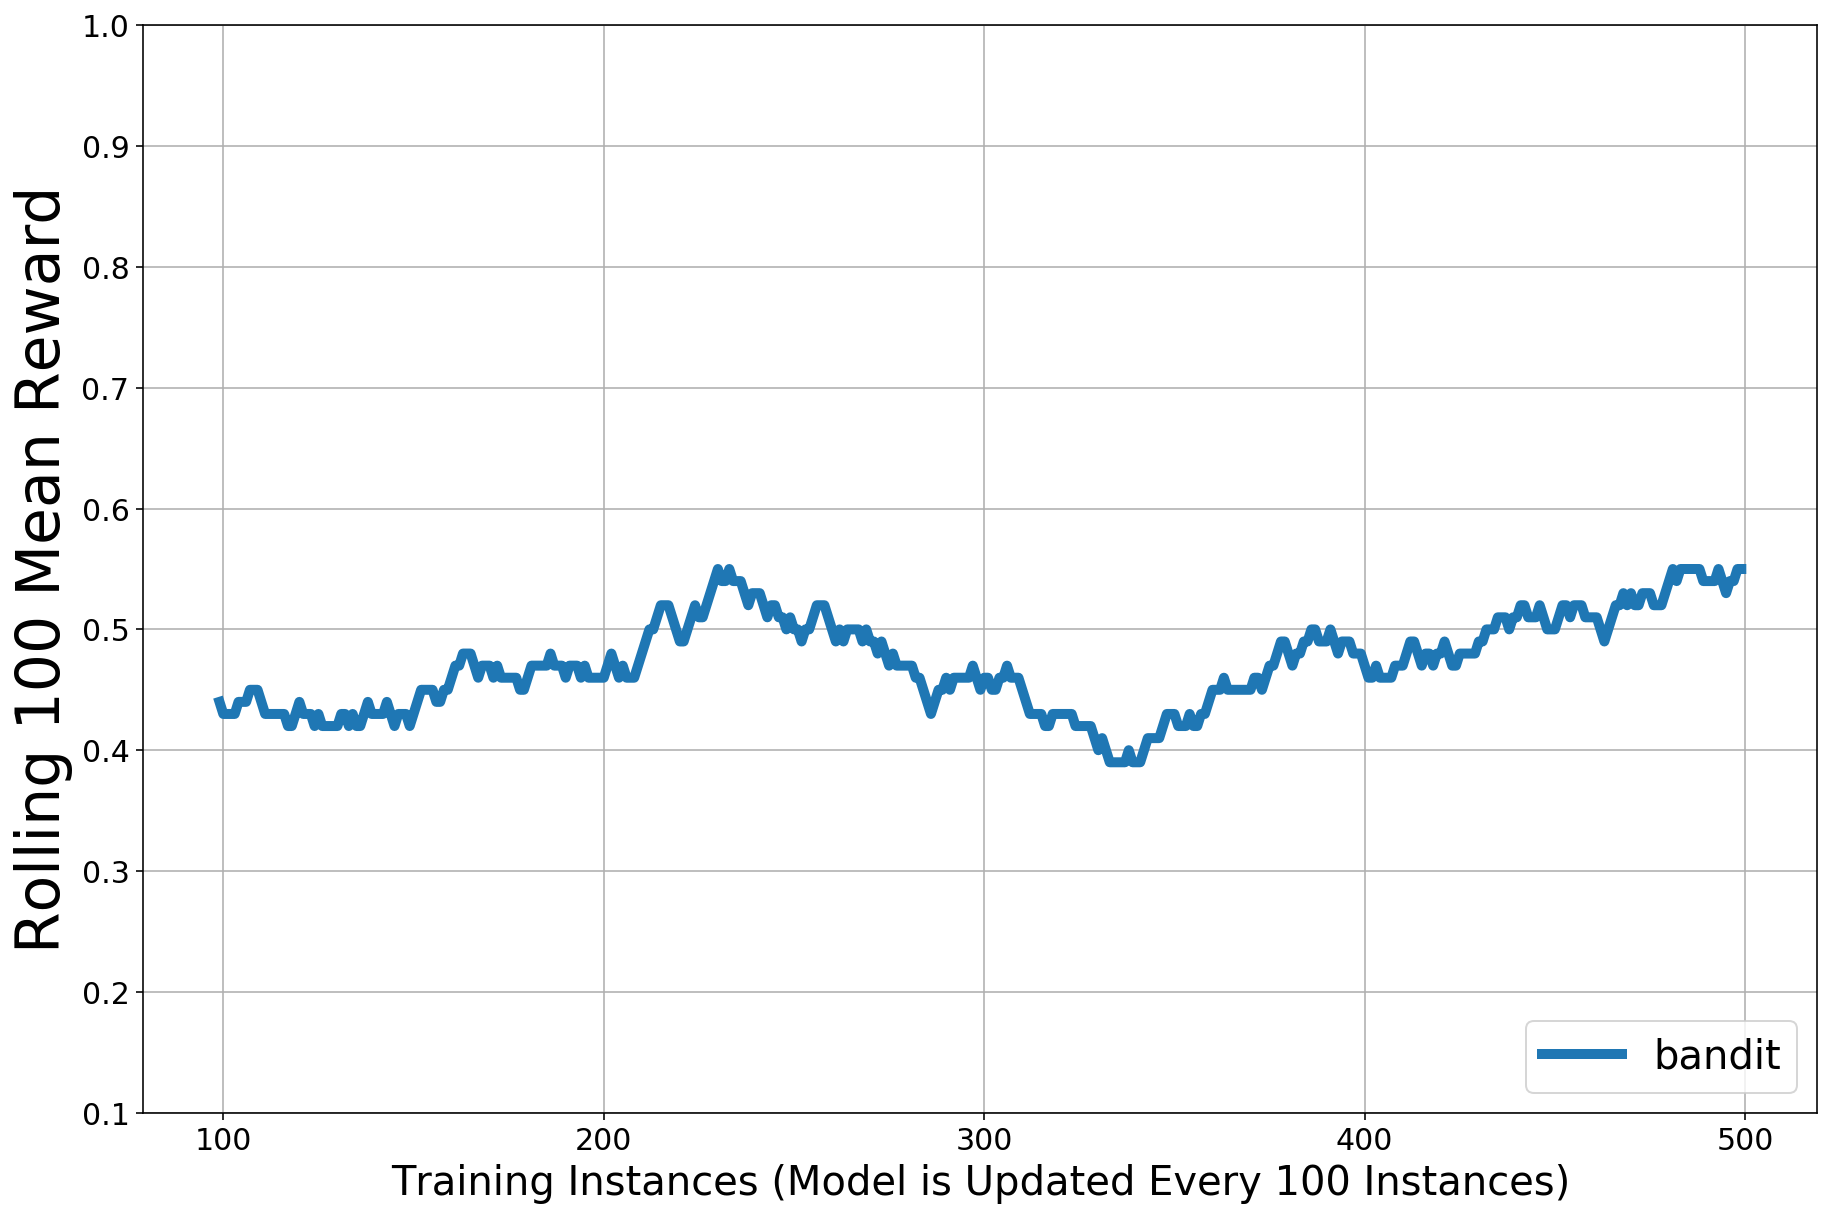

In [101]:
rewards_df.plot(y=['bandit'],  #, 'perfect'], 
                linewidth=lwd)
plt.legend(loc=4, prop={'size': 20})
plt.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
plt.xticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

plt.xlabel('Training Instances (Model is Updated Every %s Instances)' % retrain_batch_size, size=20)
plt.ylabel('Rolling {} Mean Reward'.format(rolling_window), size=30)
plt.grid()
plt.show()

In [97]:
rewards_df['bandit'].mean()

0.4724688279301748

# Monitor the Bandit Model in CloudWatch

In [98]:
from markdown_helper import *
from IPython.display import Markdown

display(Markdown(bandit_experiment_manager.get_cloudwatch_dashboard_details()))

You can monitor your Training/Hosting evaluation metrics on this [CloudWatch Dashboard](https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#dashboards:name=bandits-1610163172;start=PT1H)

(Note: This would need Trained/Hosted Models to be evaluated in order to publish Evaluation Scores)